## Ejercicio 1.4

Una empresa desarrolló un sistema de energía solar para calentar el agua para una caldera que es parte del sistema de energía del proceso productivo. Existe el interés de controlar la estabilidad del sistema, para ello se monitorea el mismo y se registran los datos cada hora. Los datos se encuentran disponibles en el archivo energia.xlsx

In [4]:
library(readxl)
library(ggplot2)
library(dplyr)
library(MVN)
library(corrplot)
library(aod)
library(lmtest)
library(car)
library(MASS)

In [5]:
PARAM <- list()
PARAM$HOME <- "C://Austral/mcd-reg-adv/datasets/"
PARAM$FILE <- "energia.xlsx"
file_name <- paste0(PARAM$HOME,PARAM$FILE)

In [9]:
energia <- read_excel( file_name )
head(energia)

Hora,Energía
<dbl>,<dbl>
1,598
2,527
3,530
4,528
5,452
6,497


### a) Realizar el diagrama de dispersión y evaluar si un modelo de regresión lineal es adecuado

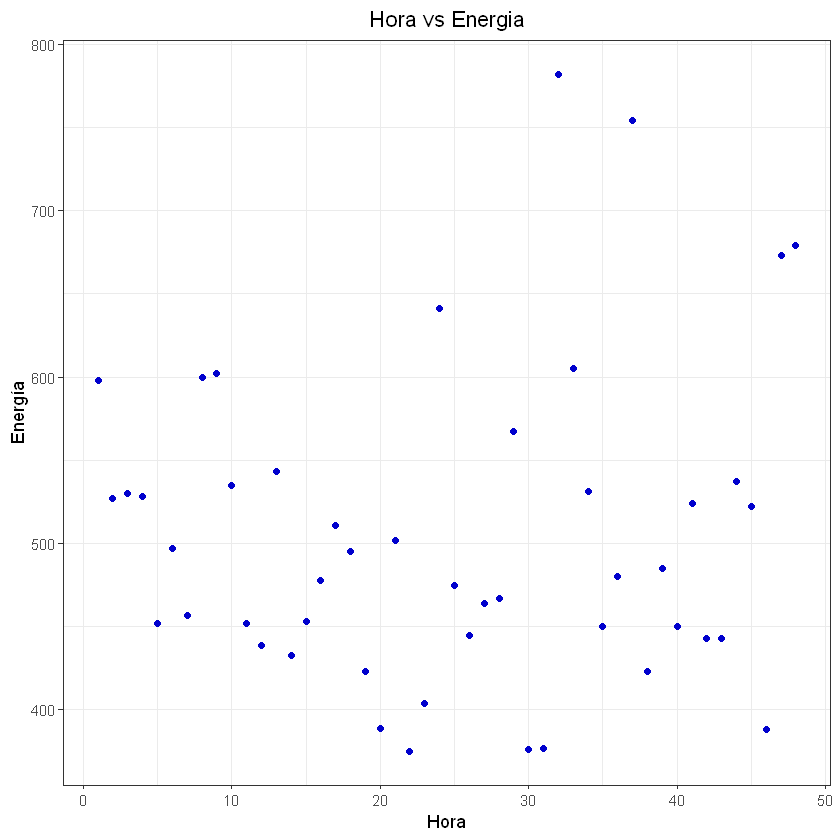

In [11]:
ggplot( data = energia, aes ( x = Hora, y = Energía ) ) +
    geom_point( colour = "blue3" ) + 
    ggtitle( "Hora vs Energia" ) +
    theme_bw() +
    theme( plot.title = element_text( hjust = 0.5 ) )

A primera vista, un modelo de regresión lineal no parecería ser indicado debido a que se observa una nube de puntos con mucha dispersion

### b) Esimar un modelo lineal y verificar la normalidad de los residuos del mismo

In [12]:
modenerg1 <- lm( Energía ~ Hora, data = energia )
summary( modenerg1 )


Call:
lm(formula = Energía ~ Hora, data = energia)

Residuals:
    Min      1Q  Median      3Q     Max 
-131.12  -60.60  -24.31   37.29  273.84 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 491.4894    27.5044  17.869   <2e-16 ***
Hora          0.5208     0.9772   0.533    0.597    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 93.79 on 46 degrees of freedom
Multiple R-squared:  0.006138,	Adjusted R-squared:  -0.01547 
F-statistic: 0.2841 on 1 and 46 DF,  p-value: 0.5966


In [13]:
shapiro.test( modenerg1$residuals )


	Shapiro-Wilk normality test

data:  modenerg1$residuals
W = 0.92988, p-value = 0.006752


Se rechaza normalidad de los residuos

### c) En caso de rechazar este supuesto, buscar una transformación lineal para este modelo y aplicarla

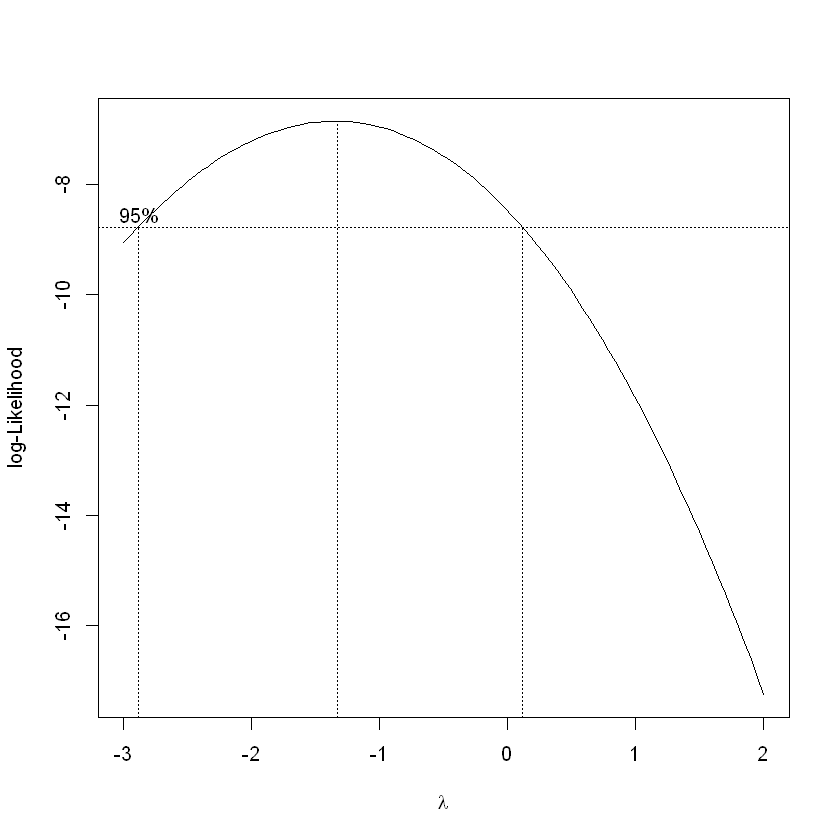

In [30]:
bc <- boxcox( Energía ~ Hora, lambda = -3:2, data = energia )

In [32]:
lambda <- bc$x[ which.max(bc$y) ]
lambda

[1] -1.333333

El gráfico sugiere una transformación exponencial de -1.333

Las transformaciones habituales de las variables individuales pueden escribirse mediante la familia potencial de Box-Cox:

$$ y^\lambda = \dfrac{x^\lambda-1}{\lambda} \quad para \lambda \neq 0$$

$$ y^\lambda = log(x) \quad para \lambda = 0$$

In [33]:
#Arreglar la transformación
modenerg2 <- lm( ( ( Energía^(lambda) - 1 ) / lambda ) ~ Hora, data = energia )
summary( modenerg2 )


Call:
lm(formula = ((Energía^(lambda) - 1)/lambda) ~ Hora, data = energia)

Residuals:
       Min         1Q     Median         3Q        Max 
-8.172e-05 -2.552e-05 -2.685e-06  2.318e-05  9.145e-05 

Coefficients:
             Estimate Std. Error   t value Pr(>|t|)    
(Intercept) 7.498e-01  1.268e-05 59110.662   <2e-16 ***
Hora        7.952e-09  4.507e-07     0.018    0.986    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.326e-05 on 46 degrees of freedom
Multiple R-squared:  6.768e-06,	Adjusted R-squared:  -0.02173 
F-statistic: 0.0003113 on 1 and 46 DF,  p-value: 0.986


In [34]:
shapiro.test( modenerg2$residuals )


	Shapiro-Wilk normality test

data:  modenerg2$residuals
W = 0.98002, p-value = 0.5795


Luego de la transformación Box-Cox no rechazamos normalidad de los residuos.

### d) Realizar un análisis diagnóstico del nuevo modelo y estimar un intervalo de confianza y un intervalo de predicción para 27.5 horas con ambos modelos. Comparar los intervalos

#### Análisis diagnóstico del Modelo 1 (Breusk-Pagan y Durbin-Watson)

In [35]:
bptest( modenerg1 ) 


	studentized Breusch-Pagan test

data:  modenerg1
BP = 3.3397, df = 1, p-value = 0.06763


No se rechaza hipótesis nula de homocedasticidad: es decir, no existen elementos suficientes para rechazar homocedasticidad.

In [36]:
dwt( modenerg1 )

 lag Autocorrelation D-W Statistic p-value
   1      0.01749477      1.871988   0.504
 Alternative hypothesis: rho != 0

No se rechaza hipótesis nula de no autocorrelación.

### Análisis diagnóstico del Modelo 2 (Breusk-Pagan y Durbin-Watson)

In [37]:
bptest( modenerg2 )


	studentized Breusch-Pagan test

data:  modenerg2
BP = 3.448, df = 1, p-value = 0.06333


No se rechaza hipótesis nula de homocedasticidad: es decir, no existen elementos suficientes para rechazar homocedasticidad.

In [38]:
dwt( modenerg2 )

 lag Autocorrelation D-W Statistic p-value
   1      0.01762354      1.882638   0.584
 Alternative hypothesis: rho != 0

No se rechaza hipótesis nula de no autocorrelación.

Conclusión: en el modelo 2 se verifican los 3 supuestos del modelo lineal.

In [39]:
IC_modenerg1 <- predict( modenerg1, newdata = data.frame( Hora = 27.5 ), interval = "confidence" )
IP_modenerg1 <- predict( modenerg1, newdata = data.frame( Hora = 27.5 ), interval = "prediction" )

IC_modenerg2 <- predict( modenerg2, newdata = data.frame( Hora = 27.5 ), interval = "confidence" )
IP_modenerg2 <- predict( modenerg2, newdata = data.frame( Hora = 27.5 ), interval = "prediction" )

In [40]:
IC_modenerg1
IC_modenerg2

,fit,lwr,upr
1,505.8125,477.9305,533.6945


,fit,lwr,upr
1,0.7498044,0.7497916,0.7498173


In [41]:
IP_modenerg1
IP_modenerg2

,fit,lwr,upr
1,505.8125,314.9688,696.6563


,fit,lwr,upr
1,0.7498044,0.7497164,0.7498924
